In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np

from random import randint
from db.session import get_last_data_by_symbol
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

In [12]:
recordsAll = get_last_data_by_symbol(symbol="h")
#recordsAll = get_last_data_by_symbol(symbol="xem")

# Convert result to Pandas DataFrame
df = pd.DataFrame(recordsAll.fetchall(), columns=list(recordsAll.keys()))

# Set the timestamp column as the index
df.set_index('created_at', inplace=True)

**Prepare Data**

In [13]:
df["price_change"] = df["lastPrice"].pct_change()
df["volume_change"] = df["volume24h"].pct_change()
df["bid_ask_ratio"] = (df["bid1Size"] / (df["ask1Size"] + 1e-9))

df["mean_price_2"] = df["price_change"].rolling(window=2).mean()
df["mean_price_4"] = df["price_change"].rolling(window=4).mean()
#df["mean_price_8"] = df["price_change"].rolling(window=8).mean()

df["mean_volume_2"] = df["volume_change"].rolling(window=2).mean()
df["mean_volume_4"] = df["volume_change"].rolling(window=4).mean()
#df["mean_volume_8"] = df["volume_change"].rolling(window=8).mean()
df["mean_volume_8_16"] = df["volume_change"].shift(8).rolling(window=8).mean()
df["mean_volume_16_32"] = df["volume_change"].shift(16).rolling(window=16).mean()
df["mean_volume_32_64"] = df["volume_change"].shift(32).rolling(window=32).mean()

df["mean_bid_ask_ratio_4"] = df["bid_ask_ratio"].rolling(window=4).mean()
df["mean_bid_ask_ratio_8_16"] = df["bid_ask_ratio"].shift(8).rolling(window=8).mean()
df["mean_bid_ask_ratio_16_32"] = df["bid_ask_ratio"].shift(16).rolling(window=16).mean()
df["mean_bid_ask_ratio_32_64"] = df["bid_ask_ratio"].shift(32).rolling(window=32).mean()

# Target
lp_shift_3 = df["lastPrice"].shift(-3).rolling(window=3).mean()
lp_shift_3_6 = df["lastPrice"].shift(-6).rolling(window=3).mean()

df["future_return_pcnt_3"] = (lp_shift_3 - df["lastPrice"]) / df["lastPrice"] * 100
df["future_return_pcnt_6"] = (lp_shift_3_6 - df["lastPrice"]) / df["lastPrice"] * 100
df["final_target_7_after_6_period"] = (df["future_return_pcnt_6"] >= 7).astype(int)
df["final_target_5_after_3_period"] = (df["future_return_pcnt_3"] >= 5).astype(int)

# Final target combining both conditions*
df["final_target"] = df["final_target_7_after_6_period"]

skewness = df["lastPrice"].skew()
kurtosis = df["lastPrice"].kurtosis()
min_price = df["lastPrice"].min()
max_price = df["lastPrice"].max()
price_difference = max_price - min_price
percentage_difference_from_min = (price_difference / min_price) * 100
mode_price = df['lastPrice'].mode().iloc[0]

print(f"Skewness of lastPrice: {skewness}")
print(f"Kurtosis of lastPrice: {kurtosis}")
print(f"Minimum of lastPrice: {min_price}")
print(f"Maximum of lastPrice: {max_price}")
print(f"Mode of lastPrice: {mode_price}")
print(f"Percentage Difference from Minimum: {percentage_difference_from_min}%")

# Drop rows with NaN values
df.dropna(inplace=True)

Skewness of lastPrice: -0.017249622122417506
Kurtosis of lastPrice: -0.7692428506880726
Minimum of lastPrice: 0.0025
Maximum of lastPrice: 0.10612
Mode of lastPrice: 0.020056
Percentage Difference from Minimum: 4144.8%


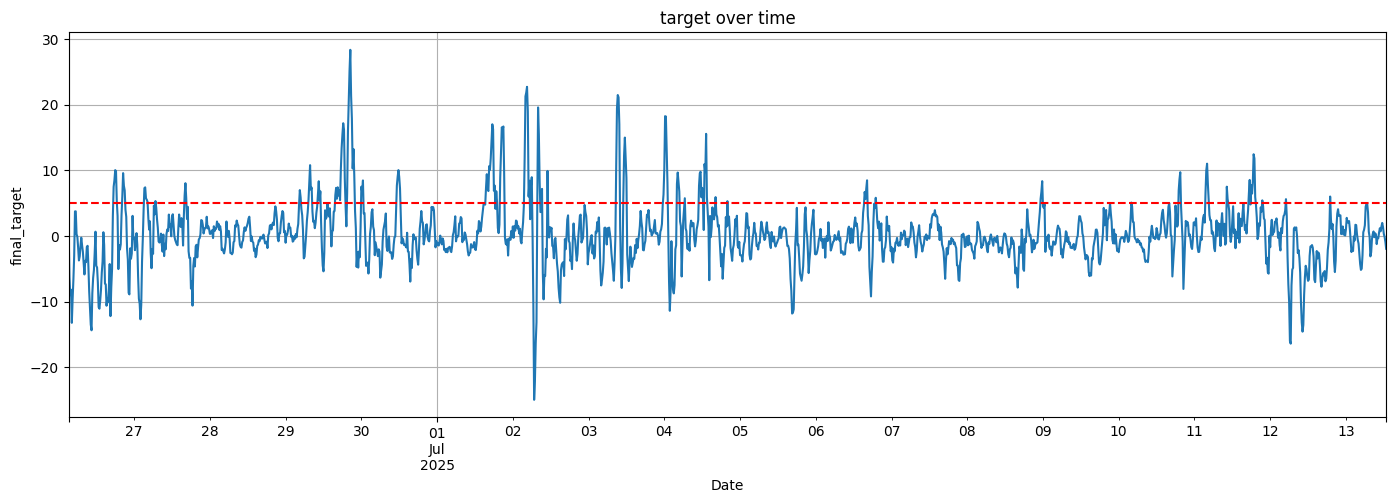

In [14]:
df["future_return_pcnt_6"].plot(figsize=(17, 5), title="target over time")

plt.xlabel("Date")
plt.ylabel("final_target")
plt.grid(True)
# a line at y=5
plt.axhline(y=5, color='r', linestyle='--', label='Threshold 5%')
plt.show()

In [15]:

# Define the columns for scalling
columns_to_scale = ["price_change", "volume_change", "bid_ask_ratio", 
                    "mean_price_2", "mean_price_4","mean_volume_2", "mean_volume_4", 
                    "mean_volume_8_16", "mean_bid_ask_ratio_4", "mean_bid_ask_ratio_8_16",
                    "mean_volume_16_32", "mean_volume_32_64",
                    "mean_bid_ask_ratio_16_32", "mean_bid_ask_ratio_32_64"]

# 1. Select column
df_to_scale = df[columns_to_scale]

# 2. Create and learn the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df_to_scale)

# 3. Return to DataFrame
scaled_df_part = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df.index)
final_scaled_df = pd.concat([scaled_df_part, df["final_target"]], axis=1)


In [19]:
# Prepare tensor data
X = final_scaled_df[columns_to_scale].values
y = final_scaled_df["final_target"].values
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
total = len(y)
target_count = int(y.sum().item())

print(f"X shape: {X.shape}, y shape: {y.shape}, total samples: {total}, target count: {target_count}")

X shape: torch.Size([1671, 14]), y shape: torch.Size([1671, 1]), total samples: 1671, target count: 106


In [21]:
# Анализируем ваши данные
print(f"Количество признаков: {X.shape[1]}")
print(f"Количество образцов: {X.shape[0]}")
print(f"Соотношение классов: {y.mean():.3f}")

# Правило: параметров должно быть меньше образцов
input_dim = X.shape[1]
samples = X.shape[0]
print(f"Максимальное количество параметров: {samples // 10}")

Количество признаков: 14
Количество образцов: 1671
Соотношение классов: 0.063
Максимальное количество параметров: 167


In [22]:
def suggest_hidden_size(input_dim, output_dim, samples):
    """Рекомендации для размера скрытого слоя"""
    
    # Правило 1: 2/3 от входа + выход
    rule1 = int(2/3 * input_dim + output_dim)
    
    # Правило 2: Меньше чем вход
    rule2 = int(input_dim * 0.5)
    
    # Правило 3: Корень из произведения
    rule3 = int((input_dim * output_dim) ** 0.5)
    
    # Правило 4: Степень двойки
    rule4 = 2 ** int(np.log2(input_dim))
    
    print(f"Рекомендации для скрытого слоя:")
    print(f"Правило 2/3+выход: {rule1}")
    print(f"Правило 50% входа: {rule2}")
    print(f"Правило корня: {rule3}")
    print(f"Правило степени 2: {rule4}")
    
    return [rule1, rule2, rule3, rule4]

# Для ваших данных
suggestions = suggest_hidden_size(X.shape[1], 1, X.shape[0])
print(X.shape[1], X.shape[0])

Рекомендации для скрытого слоя:
Правило 2/3+выход: 10
Правило 50% входа: 7
Правило корня: 3
Правило степени 2: 8
14 1671


**Model**

In [23]:
class NetCatcher(nn.Module):
    def __init__(self, input_dim, num_hidden, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.layer2 = nn.Linear(num_hidden, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.tanh(x) # [-1, 1] - это НЕ вероятности!
        x = self.layer2(x)
        x = torch.sigmoid(x)  # Добавляем сигмоиду для получения вероятностей [0, 1]
        return x

In [ ]:
class NetCatcherDropout(nn.Module):
    def __init__(self, input_dim, num_hidden, output_dim, dropout=0.2):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.dropout = nn.Dropout(dropout)
        self.layer2 = nn.Linear(num_hidden, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.tanh(x)
        x = self.dropout(x)  # Регуляризация
        x = self.layer2(x)
        x = torch.sigmoid(x)
        return x

**Initialization**

In [34]:
# Пересоздайте модель с правильной инициализацией
model = NetCatcher(input_dim=X.shape[1], num_hidden=16, output_dim=1)
#model = NetCatcherImproved(input_dim=X.shape[1], num_hidden=8, output_dim=1)

# Инициализируем веса
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Проверяем выходы
model.eval()
with torch.no_grad():
    test_outputs = model(X[:10])
    print(f"After init - outputs range: [{test_outputs.min():.3f}, {test_outputs.max():.3f}]")

# Теперь можно обучать
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)


After init - outputs range: [0.353, 0.525]
NetCatcher(
  (layer1): Linear(in_features=14, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=1, bias=True)
)


In [33]:
print(list(model.parameters()))


[Parameter containing:
tensor([[ 5.6822e-02, -2.0236e-01,  2.9595e-01, -3.8830e-01,  6.7446e-02,
         -7.6533e-02, -4.3696e-03, -2.9571e-01, -1.4610e-01, -1.2241e-01,
          1.4032e-01, -4.2450e-03, -2.6422e-02,  2.9806e-02],
        [ 9.8986e-02,  1.9800e-01, -2.2783e-01, -1.7559e-01, -1.5311e-02,
         -1.6504e-01, -5.9712e-02, -4.6954e-02, -1.8159e-01, -1.3562e-01,
          3.8198e-01,  4.0138e-01, -3.6146e-01, -3.2120e-01],
        [ 4.0527e-01, -6.3014e-02, -2.8373e-01, -3.4025e-01, -1.4089e-01,
         -2.4691e-01,  1.4448e-01,  1.7947e-01, -5.0642e-02, -2.2529e-01,
          3.0247e-01,  2.7369e-01, -3.0577e-01, -3.1022e-01],
        [ 4.0854e-01, -4.3306e-01, -2.4223e-01, -2.9000e-01, -3.8899e-01,
          4.0273e-01,  4.4699e-01, -5.0001e-02,  9.9064e-02, -1.2582e-02,
         -6.8575e-02, -2.4060e-03, -6.2881e-02, -1.7506e-01],
        [-1.6943e-01,  7.4786e-02,  7.1569e-03,  1.1385e-01,  3.2886e-01,
          3.9232e-01,  2.4071e-01,  2.4065e-01, -5.6378e-02, -1

**Evaluate**

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
from datetime import datetime

model.eval()
with torch.no_grad():
    # Получаем предсказания
    raw_outputs = model(X)
    # Несмотря на то, что в вашей модели последним слоем стоит tanh, для задачи бинарной классификации с BCEWithLogitsLoss обычно выход модели должен быть "сырым" (logits), а не вероятностью. 
    # BCEWithLogitsLoss сам внутри применяет сигмоиду, поэтому для получения вероятности для метрик и анализа мы явно применяем torch.sigmoid.
    # Если бы вы использовали nn.Sigmoid() как последний слой, то сигмоиду отдельно применять не нужно было бы.
    # Но у вас tanh, а не sigmoid, поэтому torch.sigmoid(outputs) даст корректную вероятность для бинарной классификации.
    
    # 2. Преобразуем в вероятности
    probabilities = raw_outputs #torch.sigmoid(raw_outputs)
    print(f"Probabilities range: [{probabilities.min():.3f}, {probabilities.max():.3f}]")
    
    # 3. Получаем бинарные предсказания
    predictions = (probabilities > 0.5).float()
    
    # Преобразуем в numpy для sklearn метрик
    y_true = y.cpu().numpy().flatten() if isinstance(y, torch.Tensor) else np.asarray(y).flatten()
    y_pred = predictions.cpu().numpy().flatten()
    y_proba = probabilities.cpu().numpy().flatten()
    
    # Вычисляем метрики
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # ROC AUC только если есть оба класса
    if len(np.unique(y_true)) > 1:
        roc_auc = roc_auc_score(y_true, y_proba)
    else:
        roc_auc = "N/A (only one class present)"
    
    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc}")
    
    print(f"Класс 0: {np.sum(y_true == 0)} ({np.mean(y_true == 0)*100:.1f}%)")
    print(f"Класс 1: {np.sum(y_true == 1)} ({np.mean(y_true == 1)*100:.1f}%)")
    
    print(f"Предсказано 0: {np.sum(y_pred == 0)} ({np.mean(y_pred == 0)*100:.1f}%)")
    print(f"Предсказано 1: {np.sum(y_pred == 1)} ({np.mean(y_pred == 1)*100:.1f}%)")
    print(f"\nМатрица ошибок:")
    print(cm)
    print(f"\nДетальный отчет:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"\nДата: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Probabilities range: [0.186, 0.697]
Accuracy: 0.8707
Precision: 0.1605
Recall: 0.2453
F1-Score: 0.1940
ROC-AUC: 0.6580083187654471
Класс 0: 1565 (93.7%)
Класс 1: 106 (6.3%)
Предсказано 0: 1509 (90.3%)
Предсказано 1: 162 (9.7%)

Матрица ошибок:
[[1429  136]
 [  80   26]]

Детальный отчет:
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      1565
         1.0       0.16      0.25      0.19       106

    accuracy                           0.87      1671
   macro avg       0.55      0.58      0.56      1671
weighted avg       0.90      0.87      0.88      1671


Дата: 2025-07-13 15:22:44


[[TN, FP],
 [FN, TP]]
 
TN (True Negative): 
Истинно Отрицательные - Модель правильно предсказала класс 0 (цена не повысится), когда истинный класс тоже был 0.
FP (False Positive): 
Ложноположительные - Модель ошибочно предсказала класс 1 (цена повысится), когда истинный класс был 0.
FN (False Negative): 
Ложноотрицательные - Модель ошибочно предсказала класс 0 (цена не повысится), когда истинный класс был 1. 
TP (True Positive): 
Истинно Положительные - Модель правильно предсказала класс 1 (цена повысится), когда истинный класс тоже был 1.

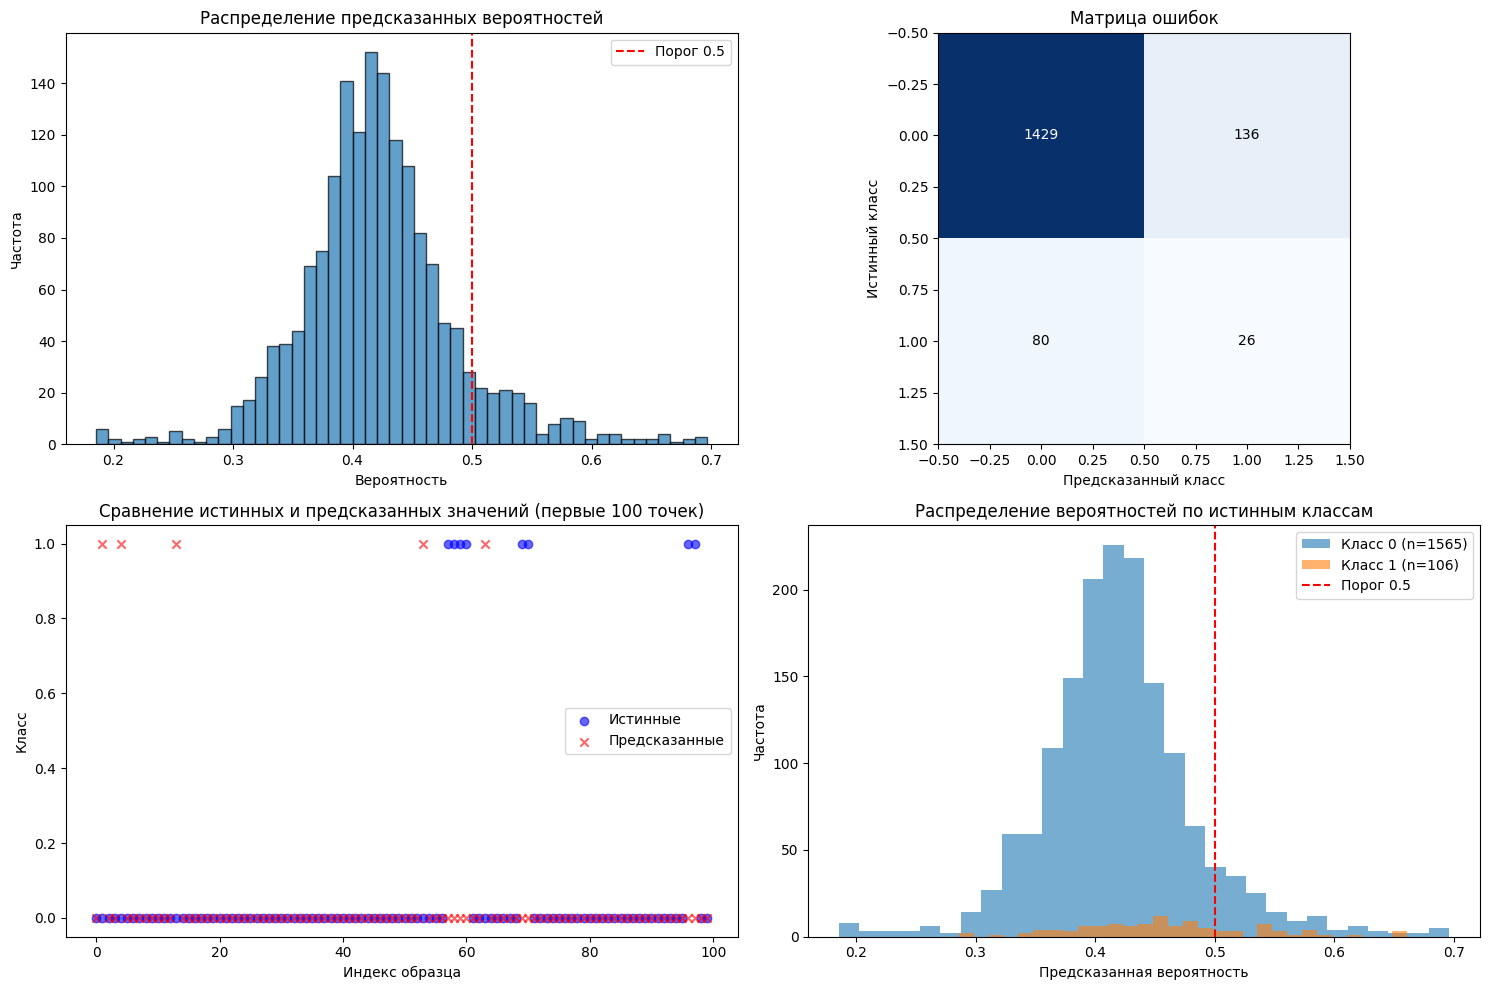

In [36]:
# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Распределение вероятностей
axes[0, 0].hist(y_proba, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Распределение предсказанных вероятностей')
axes[0, 0].set_xlabel('Вероятность')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', label='Порог 0.5')
axes[0, 0].legend()

# 2. Матрица ошибок
im = axes[0, 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0, 1].set_title('Матрица ошибок')
axes[0, 1].set_xlabel('Предсказанный класс')
axes[0, 1].set_ylabel('Истинный класс')
# Добавляем числа в ячейки
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0, 1].text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > cm.max() / 2. else "black")

# 3. Сравнение истинных и предсказанных значений (первые 100 точек)
sample_size = min(100, len(y_true))
x_axis = range(sample_size)
axes[1, 0].scatter(x_axis, y_true[:sample_size], alpha=0.6, label='Истинные', color='blue')
axes[1, 0].scatter(x_axis, y_pred[:sample_size], alpha=0.6, label='Предсказанные', color='red', marker='x')
axes[1, 0].set_title(f'Сравнение истинных и предсказанных значений (первые {sample_size} точек)')
axes[1, 0].set_xlabel('Индекс образца')
axes[1, 0].set_ylabel('Класс')
axes[1, 0].legend()

# 4. Распределение вероятностей по классам
for class_val in [0, 1]:
    mask = y_true == class_val
    if np.sum(mask) > 0:
        axes[1, 1].hist(y_proba[mask], bins=30, alpha=0.6, 
                       label=f'Класс {class_val} (n={np.sum(mask)})')
axes[1, 1].set_title('Распределение вероятностей по истинным классам')
axes[1, 1].set_xlabel('Предсказанная вероятность')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].axvline(x=0.5, color='red', linestyle='--', label='Порог 0.5')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


=== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ===


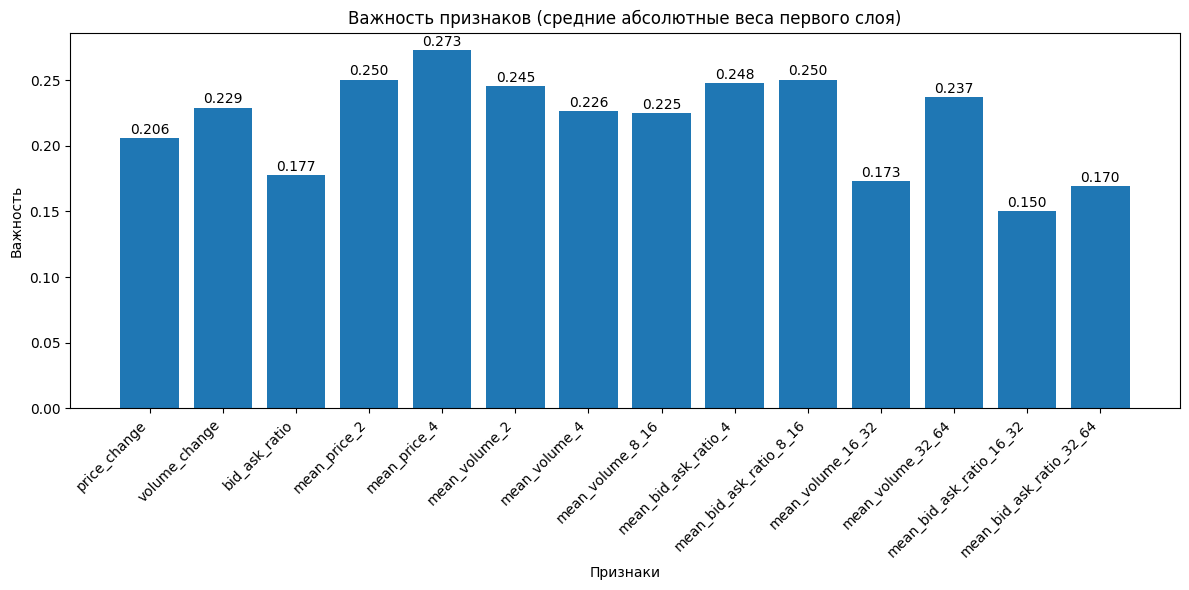


Топ-5 самых важных признаков:
mean_price_4: 0.2727
mean_price_2: 0.2504
mean_bid_ask_ratio_8_16: 0.2503
mean_bid_ask_ratio_4: 0.2479
mean_volume_2: 0.2455

=== ДОПОЛНИТЕЛЬНАЯ ДИАГНОСТИКА ===
Средняя предсказанная вероятность: 0.4219
Стандартное отклонение вероятностей: 0.0651
Минимальная вероятность: 0.1855
Максимальная вероятность: 0.6965
Уникальных значений вероятностей: 1134 из 1671

Ошибки классификации:
Ложноположительные (FP): 136
Ложноотрицательные (FN): 80
Средняя вероятность для FP: 0.5521
Средняя вероятность для FN: 0.4247


In [37]:
# Анализ важности признаков (веса первого слоя)
print("\n=== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ===")
first_layer_weights = model.layer1.weight.data.numpy()
feature_importance = np.abs(first_layer_weights).mean(axis=0)

plt.figure(figsize=(12, 6))
feature_names = columns_to_scale
bars = plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Важность признаков (средние абсолютные веса первого слоя)')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')

# Добавляем значения на столбцы
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{feature_importance[i]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Выводим топ-5 самых важных признаков
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nТоп-5 самых важных признаков:")
for i, row in importance_df.head().iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

# Дополнительная диагностика
print(f"\n=== ДОПОЛНИТЕЛЬНАЯ ДИАГНОСТИКА ===")
print(f"Средняя предсказанная вероятность: {y_proba.mean():.4f}")
print(f"Стандартное отклонение вероятностей: {y_proba.std():.4f}")
print(f"Минимальная вероятность: {y_proba.min():.4f}")
print(f"Максимальная вероятность: {y_proba.max():.4f}")

# Проверяем, есть ли признаки переобучения
unique_probs = len(np.unique(np.round(y_proba, 4)))
total_samples = len(y_proba)
print(f"Уникальных значений вероятностей: {unique_probs} из {total_samples}")
if unique_probs < total_samples * 0.1:
    print("⚠️  Предупреждение: Мало уникальных вероятностей - возможно переобучение!")

# Анализ ошибок
false_positives = np.sum((y_pred == 1) & (y_true == 0))
false_negatives = np.sum((y_pred == 0) & (y_true == 1))
print(f"\nОшибки классификации:")
print(f"Ложноположительные (FP): {false_positives}")
print(f"Ложноотрицательные (FN): {false_negatives}")

if false_positives > 0:
    fp_probs = y_proba[(y_pred == 1) & (y_true == 0)]
    print(f"Средняя вероятность для FP: {fp_probs.mean():.4f}")

if false_negatives > 0:
    fn_probs = y_proba[(y_pred == 0) & (y_true == 1)]
    print(f"Средняя вероятность для FN: {fn_probs.mean():.4f}")

**Training**

In [27]:
for epoch in range(50000):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X)
    
    # Compute loss
    loss = criterion(outputs, y)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}")


Epoch [1/1000], Loss: 0.3897
Epoch [101/1000], Loss: 0.2360
Epoch [201/1000], Loss: 0.2306
Epoch [301/1000], Loss: 0.2265
Epoch [401/1000], Loss: 0.2238
Epoch [501/1000], Loss: 0.2222
Epoch [601/1000], Loss: 0.2212
Epoch [701/1000], Loss: 0.2204
Epoch [801/1000], Loss: 0.2197
Epoch [901/1000], Loss: 0.2191
Epoch [1001/1000], Loss: 0.2184
Epoch [1101/1000], Loss: 0.2178
Epoch [1201/1000], Loss: 0.2172
Epoch [1301/1000], Loss: 0.2165
Epoch [1401/1000], Loss: 0.2158
Epoch [1501/1000], Loss: 0.2150
Epoch [1601/1000], Loss: 0.2142
Epoch [1701/1000], Loss: 0.2133
Epoch [1801/1000], Loss: 0.2124
Epoch [1901/1000], Loss: 0.2113
Epoch [2001/1000], Loss: 0.2103
Epoch [2101/1000], Loss: 0.2092
Epoch [2201/1000], Loss: 0.2080
Epoch [2301/1000], Loss: 0.2067
Epoch [2401/1000], Loss: 0.2054
Epoch [2501/1000], Loss: 0.2039
Epoch [2601/1000], Loss: 0.2023
Epoch [2701/1000], Loss: 0.2005
Epoch [2801/1000], Loss: 0.1986
Epoch [2901/1000], Loss: 0.1967
Epoch [3001/1000], Loss: 0.1948
Epoch [3101/1000], L

In [38]:
# save the model
torch.save(model.state_dict(), "save_models/linear_net_catcher.pth")

In [ ]:
 # getting the model from file
model = NetCatcher(input_dim=X.shape[1], num_hidden=16, output_dim=1)
model.load_state_dict(torch.load("save_models/linear_net_catcher.pth"))

**Test**

In [26]:
print(list(model.parameters()))

[Parameter containing:
tensor([[ 0.1539, -0.4302,  0.3165,  0.2280, -0.3992, -0.3135,  0.0251,  0.1623,
          0.1433,  0.1179,  0.1587, -0.1094,  0.2176, -0.1514],
        [-0.3712, -0.0762,  0.0674,  0.2916, -0.0030, -0.3667, -0.0530, -0.2181,
         -0.3516, -0.0582,  0.1970, -0.1262,  0.4084, -0.1195],
        [-0.0532,  0.1376,  0.2582,  0.1568,  0.0103, -0.0760,  0.0614, -0.4188,
         -0.1162,  0.2425, -0.0998, -0.4365,  0.4223,  0.0347],
        [ 0.3446,  0.3270,  0.2727, -0.1139,  0.4292,  0.3024, -0.1287,  0.0550,
         -0.2176,  0.2156, -0.3901,  0.3678,  0.0842,  0.0694],
        [ 0.3502, -0.3195,  0.2861,  0.0303, -0.0288,  0.2950, -0.1666, -0.4289,
          0.2049,  0.0608,  0.3318, -0.3091,  0.2723,  0.4276],
        [-0.0483,  0.3482,  0.1798,  0.4391,  0.0261,  0.1072, -0.3132,  0.1691,
          0.4343,  0.1450, -0.4420, -0.3310, -0.2999, -0.3835],
        [-0.0091,  0.1447,  0.1232,  0.2046, -0.3173,  0.0947,  0.2552,  0.3469,
         -0.2542,  0.0931,